In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [8]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_counts')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [9]:
df = get_melted_pi_counts_table('poder')

In [10]:
df.head()

,tid,gid,sample,pi,t_tpm,population,g_counts
0,ENST00000010132.6,ENSG00000010219.14,HAC2,0.408771,16.602600,HAC,457.64207
1,ENST00000013894.3,ENSG00000011198.10,HAC2,0.000000,0.000000,HAC,32.99997
2,ENST00000075120.12,ENSG00000059804.18,HAC2,0.000000,0.000000,HAC,61.99995
3,ENST00000155093.8,ENSG00000067646.12,HAC2,1.000000,0.621252,HAC,7.00000
4,ENST00000156084.8,ENSG00000068308.15,HAC2,0.000000,0.000000,HAC,23.86365


In [12]:
# threshes

# transcript filtering
t_cpm_thresh = 0.1 # min CPM (corresponds to ~1000 counts)
n_t_sample_thresh = 11 # min # of samples that the transcript needs to be over

# gene filtering
g_counts_thresh = 10 # min gene counts
n_g_sample_thresh = 11 # min # of samples that the gene needs to be in 

# min # of transcripts
min_n_t = 2

In [13]:
# remove anything w/ 0 pi val
# can adjust this threshold later if needed
df = df.loc[df.pi>0]

# keep transcripts that have at least 11 samples with more than 0.1 cpm
temp = df[['sample', 'tid', 't_tpm']]
temp = temp.loc[temp['t_tpm']>=t_cpm_thresh]
temp = temp.drop('t_tpm', axis=1)
temp = temp.groupby('tid').nunique().reset_index().rename({'sample':'n_t_samples'}, axis=1)
df = df.merge(temp, how='left', on='tid')

# keep genes with at least 11 samples with at least 10 counts
temp = df[['sample', 'gid', 'g_counts']]
temp = temp.loc[temp.g_counts>=g_counts_thresh]
temp = temp.drop('g_counts', axis=1)
temp = temp.groupby('gid').nunique().reset_index().rename({'sample':'n_g_samples'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# keep genes with more than 1 transcript
temp = df[['tid', 'gid']].groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# perform the filtering
df = df.loc[df.n_t_samples>=n_t_sample_thresh]
df = df.loc[df.n_g_samples>=n_g_sample_thresh]
df = df.loc[df.n_t>=min_n_t]

In [15]:
# groupby sample and gene to compute entropy 
# over pi values
e_df = df[['gid', 'sample',
           'pi', 'population', 'n_t']].groupby(['gid', 'sample',
                                         'population', 'n_t']).apply(lambda x: st.entropy(x.pi))
e_df = e_df.reset_index().rename({0:'entropy'}, axis=1)

In [17]:
# get # isoforms expressed per sample per gene vs. entropy
n_t_df = df[['tid', 'gid', 'sample']].groupby(['gid', 'sample']).nunique().reset_index().rename({'tid': 'n_exp_t'}, axis=1)
e_df = e_df.merge(n_t_df, on=['gid', 'sample'])

In [20]:
# verify that the number of expressed transcripts can be different for
# samples in the same gene and population
e_df.loc[(e_df.gid=='ENSG00000000419.14')&(e_df.population=='AJI')]

,gid,sample,population,n_t,entropy,n_exp_t
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15
5,ENSG00000000419.14,AJI6,AJI,24,0.591994,13


In [21]:
# normalize entropy values to max entropy values computed using 
# this stragtegy
# https://mc-stan.org/posterior/reference/entropy.html
e_df['norm_entropy'] = e_df.entropy/np.log(e_df.n_exp_t)

In [28]:
# fill na with 0 for genes that only expression 1 transcript?
# e_df.loc[e_df.gid=='ENSG00000000457.14']
e_df['norm_entropy'] = e_df['norm_entropy'].fillna(0)

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.245210
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.330646
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.268764
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.265340
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.289929


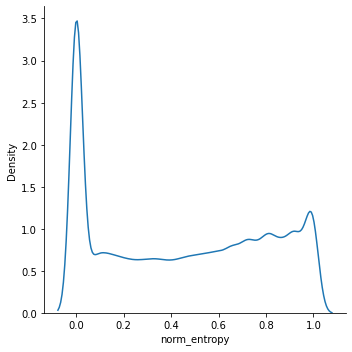

In [29]:
# plot distribution of entropies
sns.displot(e_df, kind='kde', x='norm_entropy')

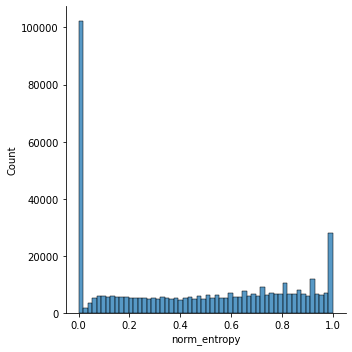

In [30]:
# plot distribution of entropies
sns.displot(e_df, kind='hist', x='norm_entropy')
# peaks are probably at the different theoretical maxes maybe?

In [31]:
# get 

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.245210
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.330646
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.268764
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.265340
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.289929
